# Cifar-100 CNN

In [ ]:
#All library imports
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict


data_pre_path = '/content/drive/MyDrive/cifar-100-python/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
data_meta_path = data_pre_path + 'meta'

# Read dictionary
data_train = unpickle(data_train_path)
data_test = unpickle(data_test_path)
data_meta = unpickle(data_meta_path)

subCategory = pd.DataFrame(data_meta['fine_label_names'], columns=['SubClass'])
subCategoryDict = subCategory.to_dict()

X_train = data_train['data']
y_train = data_train['fine_labels']

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7)

X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
X_valid = X_valid.reshape(len(X_valid),3,32,32).transpose(0,2,3,1)

#transforming the testing dataset
X_test = data_test['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
y_test = data_test['fine_labels']

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

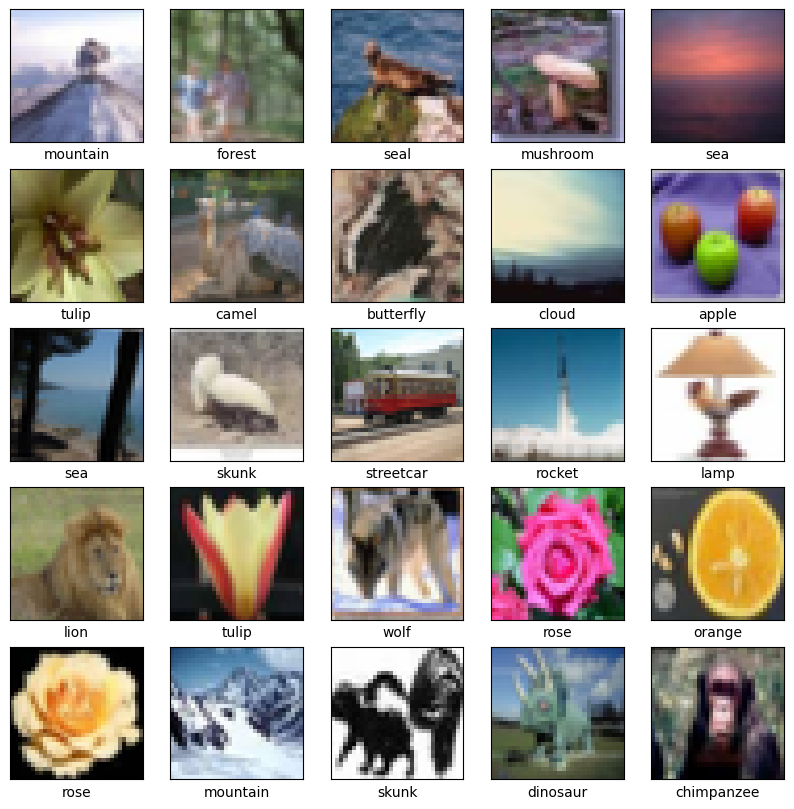

In [ ]:
# Visualizing some examples
plt.figure(figsize=(10,10))
for image in range(0,25):
    i=image
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=i+0
    data_plot = X_test[j]
    plt.imshow(data_plot)
    plt.xlabel(str(subCategoryDict['SubClass'][y_test[j]]))
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Define the function for plotting the history of the training of the model
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

In [ ]:
# Creating a simple CNN Model
model = Sequential()
model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3), padding='same', strides=(2, 2), filters=32))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same'))
model.add(Conv2D(kernel_size=(3, 3), padding='same', strides=(2, 2), filters=40,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same'))
model.add(Flatten())
model.add(Dense(180, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(150, activation='softmax'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 40)          11560     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 40)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_4 (Dense)             (None, 180)              

In [ ]:
#Define the data augmentation

augmenter = ImageDataGenerator(rescale=1.0/255.,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             fill_mode='nearest',
                             horizontal_flip=True)
rescalator=ImageDataGenerator(rescale=1.0/255.)

train_generator=augmenter.flow(X_train, y_train, batch_size=20)
valid_generator=rescalator.flow(X_valid, y_valid, batch_size=20)
test_generator=rescalator.flow(X_test, y_test, batch_size=20)

In [ ]:
#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

In [ ]:
#Training of the model
EPOCHS=50
batch_size=20
steps_per_epoch=train_generator.n//batch_size
validation_steps=valid_generator.n//batch_size
history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=EPOCHS,
                        validation_data=valid_generator,
                        validation_steps=validation_steps
                        )

Epoch 1/50
1750/1750 [==============================] - 78s 43ms/step - loss: 4.1149 - accuracy: 0.0759 - val_loss: 3.7762 - val_accuracy: 0.1174
Epoch 2/50
1750/1750 [==============================] - 85s 48ms/step - loss: 3.6451 - accuracy: 0.1362 - val_loss: 3.6290 - val_accuracy: 0.1518
Epoch 3/50
1750/1750 [==============================] - 79s 45ms/step - loss: 3.4612 - accuracy: 0.1632 - val_loss: 3.4364 - val_accuracy: 0.1781
Epoch 4/50
1750/1750 [==============================] - 76s 44ms/step - loss: 3.3534 - accuracy: 0.1827 - val_loss: 2.9990 - val_accuracy: 0.2537
Epoch 5/50
1750/1750 [==============================] - 74s 42ms/step - loss: 3.2681 - accuracy: 0.2000 - val_loss: 3.0158 - val_accuracy: 0.2429
Epoch 6/50
1750/1750 [==============================] - 79s 45ms/step - loss: 3.2176 - accuracy: 0.2094 - val_loss: 3.4502 - val_accuracy: 0.1882
Epoch 7/50
1750/1750 [==============================] - 79s 45ms/step - loss: 3.1691 - accuracy: 0.2153 - val_loss: 2.9621 -

500/500 - 4s - loss: 4.6052 - accuracy: 0.0099 - 4s/epoch - 7ms/step
test accuracy:  0.00989999994635582


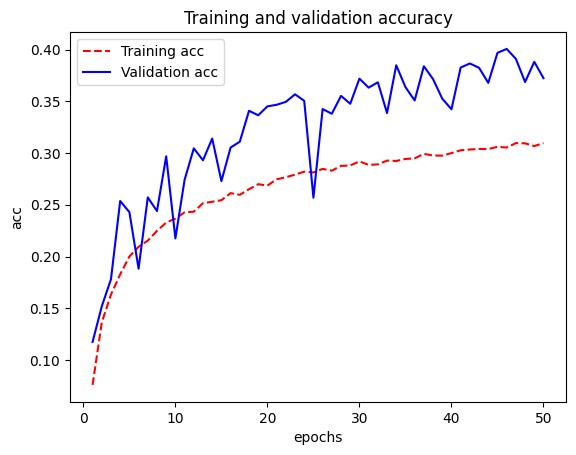

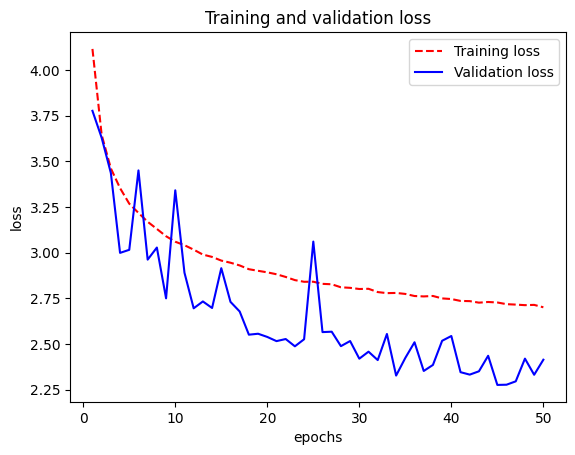

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(history)
test_loss,test_acc=model.evaluate(test_generator, verbose=2)
print("test accuracy: ",test_acc)

# Cifar-100 Transfer Learning

In [ ]:
#Pre-process the data
x_train = X_train
x_test = X_test

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [ ]:
Y_train = y_train
Y_test = y_test

In [ ]:
num_classes = 100

Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

print ("Shape after one-hot encoding:", Y_train.shape)
print ("Shape before one-hot encoding: ", Y_test.shape)

Shape after one-hot encoding: (35000, 100)
Shape before one-hot encoding:  (10000, 100)


In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top = False, input_shape = (32, 32, 3))

x = resnet_model.output
x = Flatten()(x)
x = Dense(120, activation = 'relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer = 'random_uniform')(x)

models = Model(inputs = resnet_model.input, outputs = predictions)

# Freezing pretrained layers
for layer in resnet_model.layers:
    layer.trainable=False

#optimizer = Adam()
#models.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
models.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

batch_size = 20
maxepoches = 50
shape = (32,32,3)
hist = models.fit_generator(datagen.flow(x_train, Y_train,
                                 batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0] // batch_size,
                    epochs = maxepoches,
                    validation_data = (x_test, Y_test))
model.save_weights('cifar100resnet.h5')

Epoch 1/50


<ipython-input-34-026512e3e2f0>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = models.fit_generator(datagen.flow(x_train, Y_train,


1750/1750 [==============================] - 243s 137ms/step - loss: 3.4342 - accuracy: 0.1834 - val_loss: 2.9483 - val_accuracy: 0.2614
Epoch 2/50
1750/1750 [==============================] - 238s 136ms/step - loss: 2.9149 - accuracy: 0.2710 - val_loss: 2.7908 - val_accuracy: 0.2922
Epoch 3/50
1750/1750 [==============================] - 226s 129ms/step - loss: 2.7775 - accuracy: 0.2971 - val_loss: 2.7185 - val_accuracy: 0.3082
Epoch 4/50
1750/1750 [==============================] - 229s 131ms/step - loss: 2.6833 - accuracy: 0.3134 - val_loss: 2.6898 - val_accuracy: 0.3170
Epoch 5/50
1750/1750 [==============================] - 236s 135ms/step - loss: 2.6234 - accuracy: 0.3311 - val_loss: 2.6641 - val_accuracy: 0.3165
Epoch 6/50
1750/1750 [==============================] - 237s 135ms/step - loss: 2.5784 - accuracy: 0.3375 - val_loss: 2.6774 - val_accuracy: 0.3224
Epoch 7/50
1750/1750 [==============================] - 232s 132ms/step - loss: 2.5289 - accuracy: 0.3474 - val_loss: 2.635

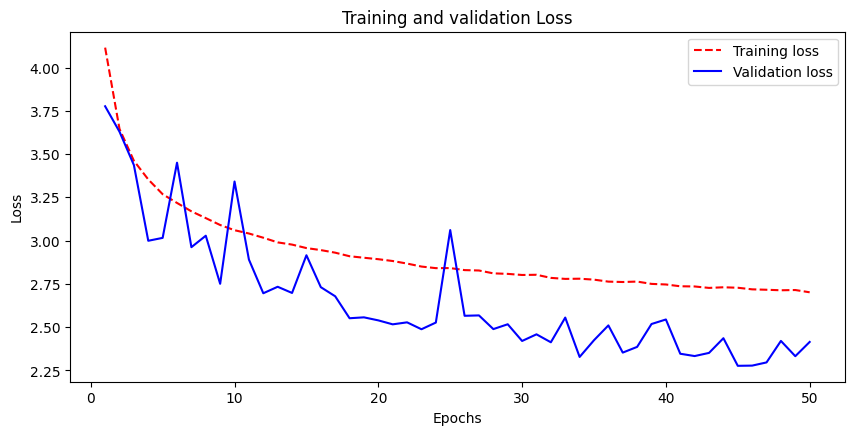

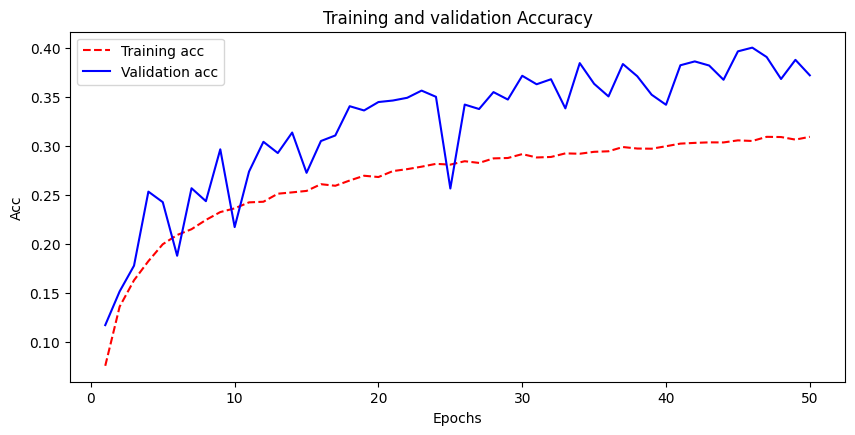

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r--', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r--', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()